In [1]:
import pandas as pd
import random
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# small dataset
sentences = [
    "I love this", "This is great", "Amazing work", "I hate this",
    "This is bad", "Very terrible", "Normal day", "Regular work",
    "Just reading book", "Happy moment", "Sad event"
]

labels = [
    "positive", "positive", "positive", "negative",
    "negative", "negative", "neutral", "neutral",
    "neutral", "positive", "negative"
]

df = pd.DataFrame({"tweet": sentences, "label": labels})

def clean(t):
    t = t.lower()
    t = re.sub(r"[^a-zA-Z ]", "", t)
    return t

df["clean"] = df["tweet"].apply(clean)

le = LabelEncoder()
df["label_enc"] = le.fit_transform(df["label"])

X_train, X_test, y_train, y_test = train_test_split(df["clean"], df["label_enc"], test_size=0.3)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

model = LogisticRegression()
model.fit(X_train_vec, y_train)

preds = model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds, target_names=le.classes_))


Accuracy: 0.0
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       2.0
     neutral       0.00      0.00      0.00       0.0
    positive       0.00      0.00      0.00       2.0

    accuracy                           0.00       4.0
   macro avg       0.00      0.00      0.00       4.0
weighted avg       0.00      0.00      0.00       4.0



c:\Users\Wahab Ullah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Wahab Ullah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Wahab Ullah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Generated dataset: 50000 samples in 5.7s
Cleaned text in 2.3s
Classes -> ['Negative' 'Neutral' 'Positive']
Train: 40000, Test: 10000
TF-IDF done in 4.9s -- Train shape: (40000, 600)
All models trained in 277.2s
                model  accuracy  train_time
0  LogisticRegression    0.9623    2.592522
1       MultinomialNB    0.9666    0.048869
2           LinearSVC    0.9635    2.814363
3        RandomForest    0.9698  260.798264


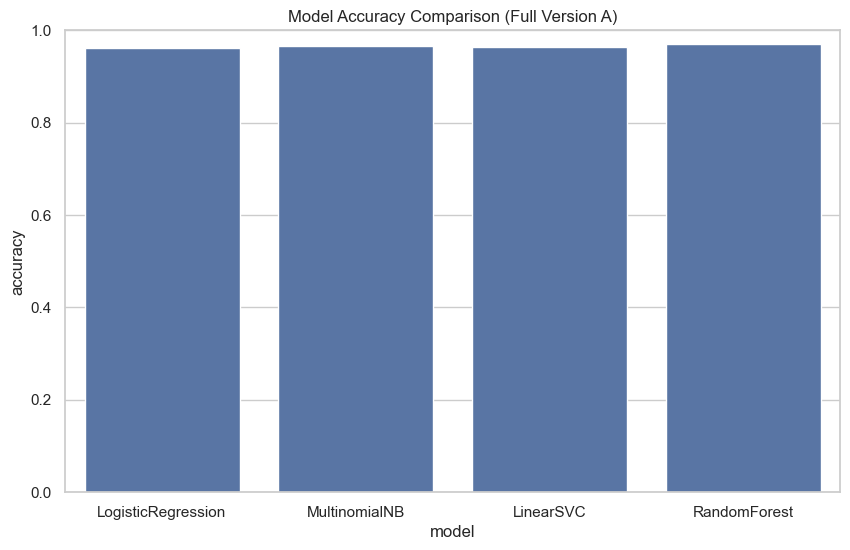

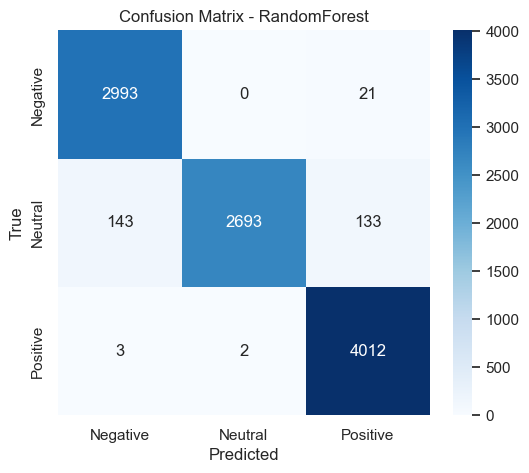

                model  roc_auc_macro
0  LogisticRegression       0.985320
1       MultinomialNB       0.986694
2           LinearSVC       0.984358
3        RandomForest       0.984465
Saved models, vectorizer and dataset.

========== LogisticRegression ==========
Accuracy: 0.9623
Train time: 2.59s
Classification report:
              precision    recall  f1-score     support
0              0.942677  0.993033  0.967200   3014.0000
1              1.000000  0.881105  0.936795   2969.0000
2              0.953671  0.999253  0.975930   4017.0000
accuracy       0.962300  0.962300  0.962300      0.9623
macro avg      0.965449  0.957797  0.959975  10000.0000
weighted avg   0.964112  0.962300  0.961680  10000.0000

========== MultinomialNB ==========
Accuracy: 0.9666
Train time: 0.05s
Classification report:
              precision    recall  f1-score     support
0              0.948905  0.992037  0.969992   3014.0000
1              1.000000  0.895588  0.944918   2969.0000
2              0.95871

In [ ]:
# Sentiment Analysis System — 



import time
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib

sns.set(style='whitegrid')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# -------------------------
# 1) Generate synthetic dataset (50k)
# -------------------------
positive_words = ["love", "awesome", "good", "fantastic", "great", "excellent", "amazing", "happy"]
negative_words = ["hate", "terrible", "bad", "awful", "worst", "poor", "sad", "disappointing"]
neutral_words  = ["okay", "fine", "average", "normal", "medium", "soso", "indifferent", "regular"]

def generate_tweet_for_label(label):
    if label == "Positive":
        words = random.choices(positive_words + neutral_words, k=random.randint(5,12))
    elif label == "Negative":
        words = random.choices(negative_words + neutral_words, k=random.randint(5,12))
    else:
        words = random.choices(neutral_words + positive_words + negative_words, k=random.randint(5,12))
    return " ".join(words)

N = 50000
labels = np.random.choice(["Positive","Negative","Neutral"], size=N, p=[0.4, 0.3, 0.3])

start = time.time()
# generate tweets in parallel
tweets = Parallel(n_jobs=-1)(delayed(generate_tweet_for_label)(lab) for lab in labels)

df = pd.DataFrame({"text": tweets, "label": labels})
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
print(f"Generated dataset: {len(df)} samples in {time.time()-start:.1f}s")

# Save raw
df.to_csv("synthetic_tweets_50k_raw.csv", index=False)

# -------------------------
# 2) Parallel cleaning
# -------------------------

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

start = time.time()
cleaned = Parallel(n_jobs=-1, backend='loky')(delayed(clean_text)(t) for t in df['text'])
df['clean_text'] = cleaned
print(f"Cleaned text in {time.time()-start:.1f}s")

# -------------------------
# 3) Encode labels and split
# -------------------------
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
classes = le.classes_
print('Classes ->', classes)

X = df['clean_text']
y = df['label_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# -------------------------
# 4) TF-IDF vectorization
# -------------------------
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
start = time.time()
X_train_t = vectorizer.fit_transform(X_train)
X_test_t  = vectorizer.transform(X_test)
print(f"TF-IDF done in {time.time()-start:.1f}s -- Train shape: {X_train_t.shape}")

# -------------------------
# 5) Model definitions (kept reasonably fast)
# -------------------------
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, n_jobs=1),
    'MultinomialNB': MultinomialNB(),
    'LinearSVC': LinearSVC(),
    'RandomForest': RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=RANDOM_STATE)
}

# helper to compute multiclass ROC-AUC (macro using one-vs-rest)
def multiclass_roc_auc_score(y_true, y_proba, average="macro"):
    # y_proba shape: (n_samples, n_classes)
    y_true_binarized = label_binarize(y_true, classes=np.arange(len(classes)))
    try:
        return roc_auc_score(y_true_binarized, y_proba, average=average, multi_class='ovr')
    except Exception:
        return None

# -------------------------
# 6) Train & evaluate in parallel
# -------------------------

def train_eval(name, clf, Xtr, ytr, Xte, yte):
    start = time.time()
    clf.fit(Xtr, ytr)
    train_time = time.time() - start
    preds = clf.predict(Xte)
    acc = accuracy_score(yte, preds)
    report = classification_report(yte, preds, output_dict=True)
    cm = confusion_matrix(yte, preds)
    proba = None
    auc = None
    if hasattr(clf, 'predict_proba'):
        proba = clf.predict_proba(Xte)
        auc = multiclass_roc_auc_score(yte, proba)
    else:
        # try decision_function -> convert to probabilities via softmax approximation only for AUC calculation
        try:
            dec = clf.decision_function(Xte)
            # if dec is 1d for binary, convert
            if dec.ndim == 1:
                # convert to two-column scores
                dec = np.vstack([-dec, dec]).T
            # softmax
            exp = np.exp(dec - np.max(dec, axis=1, keepdims=True))
            proba = exp / np.sum(exp, axis=1, keepdims=True)
            auc = multiclass_roc_auc_score(yte, proba)
        except Exception:
            proba = None
            auc = None

    return {
        'name': name,
        'model': clf,
        'accuracy': acc,
        'report': report,
        'confusion_matrix': cm,
        'roc_auc': auc,
        'train_time': train_time
    }

start_all = time.time()
results_list = Parallel(n_jobs=-1)(delayed(train_eval)(name, clf, X_train_t, y_train, X_test_t, y_test)
                                   for name, clf in models.items())

results = {r['name']: r for r in results_list}
print(f"All models trained in {time.time()-start_all:.1f}s")

# -------------------------
# 7) Reporting & plots
# -------------------------
# Accuracy comparison
acc_df = pd.DataFrame([{ 'model': name, 'accuracy': res['accuracy'], 'train_time': res['train_time']} for name,res in results.items()])
print(acc_df)

plt.figure(figsize=(10,6))
sns.barplot(x='model', y='accuracy', data=acc_df)
plt.ylim(0,1)
plt.title('Model Accuracy Comparison (Full Version A)')
plt.savefig('accuracy_comparison_full.png')
plt.show()

# Confusion matrix of best model
best = acc_df.sort_values('accuracy', ascending=False).iloc[0]['model']
best_res = results[best]
plt.figure(figsize=(6,5))
sns.heatmap(best_res['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title(f'Confusion Matrix - {best}')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix_full.png')
plt.show()

# ROC-AUC table
roc_table = []
for name,res in results.items():
    roc_table.append({'model': name, 'roc_auc_macro': res['roc_auc']})
roc_df = pd.DataFrame(roc_table)
print(roc_df)

# Save models & vectorizer & dataset
for name,res in results.items():
    joblib.dump(res['model'], f"{name}_model_full.joblib")
joblib.dump(vectorizer, 'tfidf_vectorizer_full.joblib')
df.to_csv('tweets_synthetic_full_50k.csv', index=False)

print('Saved models, vectorizer and dataset.')

# print detailed per-model reports
for name,res in results.items():
    print('\n' + '='*10 + f' {name} ' + '='*10)
    print(f"Accuracy: {res['accuracy']:.4f}")
    print(f"Train time: {res['train_time']:.2f}s")
    print('Classification report:')
    print(pd.DataFrame(res['report']).transpose())

print('Full pipeline complete.')






Cleaning done in 0.30s
LogisticRegression -> Acc: 0.9040, time: 0.05s
MultinomialNB -> Acc: 0.9060, time: 0.01s
LinearSVC -> Acc: 0.9040, time: 0.07s


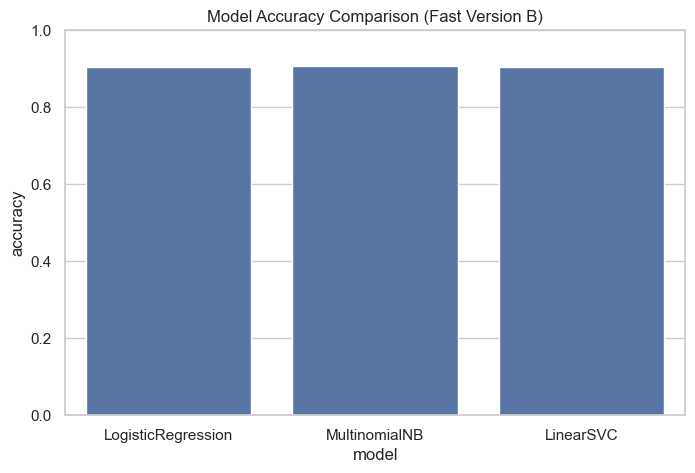

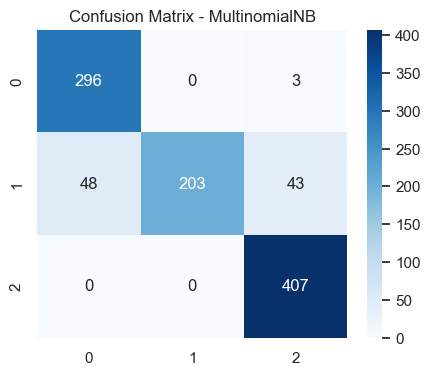

Saved fast models and dataset


'# Fast_Version_B_Notebook.ipynb\n\nThis notebook mirrors `fast_version_B.py` and contains separate cells for each step: imports, data gen, cleaning, vectorization, training, evaluation, plotting and saving. Copy the code blocks into a notebook to run interactively.\n\n---\n\n# How to use\n\n1. Open the project folder in your environment.\n2. There are two Python scripts (`full_version_A.py`, `fast_version_B.py`) and two notebooks (copy/paste notebook blocks into new .ipynb files in Jupyter Lab/Notebook).\n3. Run the scripts or the notebooks. They generate CSVs, model joblib files and PNG plots in the working directory.\n\nIf you want, I can also:\n\n* Zip these files and provide them for download.\n* Directly create `.ipynb` files and store them so you can download them.\n* Add a simple Streamlit app to test the saved models interactively.\n\nWhich extra would you like?'

In [ ]:
"""

* Setup & imports
* Synthetic data generation
* Parallel cleaning
* Vectorization
* Parallel model training
* Results, plots and saving



---


```python

- Synthetic 5k tweets
- Sequential (no heavy parallelism) for quick testing
- TF-IDF (max_features=2000)
- Models: LogisticRegression, MultinomialNB, LinearSVC
- Shows graphs and confusion matrix
"""

import time
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

sns.set(style='whitegrid')
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# 1) Generate small synthetic dataset
pos = ["love","good","nice","great","happy"]
neg = ["hate","bad","sad","terrible","awful"]
neu = ["day","book","weather","work","city"]

N = 5000
labels = np.random.choice(["Positive","Negative","Neutral"], size=N, p=[0.4,0.3,0.3])
texts = []
for lab in labels:
    if lab == 'Positive':
        words = random.choices(pos + neu, k=random.randint(3,8))
    elif lab == 'Negative':
        words = random.choices(neg + neu, k=random.randint(3,8))
    else:
        words = random.choices(neu + pos + neg, k=random.randint(3,8))
    texts.append(' '.join(words))

df = pd.DataFrame({'text': texts, 'label': labels})

def clean_text(t):
    t = str(t).lower()
    t = re.sub(r"[^a-z\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

# cleaning
start = time.time()
df['clean'] = df['text'].apply(clean_text)
print(f"Cleaning done in {time.time()-start:.2f}s")

# encode
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

# split
X_train, X_test, y_train, y_test = train_test_split(df['clean'], df['label_enc'], test_size=0.2, random_state=RANDOM_STATE, stratify=df['label_enc'])

# vectorize
vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1,2))
X_train_t = vectorizer.fit_transform(X_train)
X_test_t = vectorizer.transform(X_test)

# models (sequential)
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'MultinomialNB': MultinomialNB(),
    'LinearSVC': LinearSVC()
}

results = {}
for name,clf in models.items():
    start = time.time()
    clf.fit(X_train_t, y_train)
    train_time = time.time() - start
    preds = clf.predict(X_test_t)
    acc = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds, output_dict=True)
    cm = confusion_matrix(y_test, preds)
    results[name] = {'model':clf, 'accuracy':acc, 'report':report, 'cm':cm, 'train_time':train_time}
    print(f"{name} -> Acc: {acc:.4f}, time: {train_time:.2f}s")

# plots
acc_df = pd.DataFrame([{'model':k, 'accuracy':v['accuracy'], 'train_time':v['train_time']} for k,v in results.items()])
plt.figure(figsize=(8,5))
sns.barplot(x='model', y='accuracy', data=acc_df)
plt.ylim(0,1)
plt.title('Model Accuracy Comparison (Fast Version B)')
plt.savefig('accuracy_comparison_fast.png')
plt.show()

# confusion matrix for best
best = acc_df.sort_values('accuracy', ascending=False).iloc[0]['model']
cm = results[best]['cm']
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best}')
plt.show()

# save
for name,res in results.items():
    joblib.dump(res['model'], f"{name}_model_fast.joblib")
joblib.dump(vectorizer, 'tfidf_vectorizer_fast.joblib')
df.to_csv('tweets_synthetic_fast_5k.csv', index=False)
print('Saved fast models and dataset')



"""# Fast_Version_B_Notebook.ipynb

This notebook mirrors `fast_version_B.py` and contains separate cells for each step: imports, data gen, cleaning, vectorization, training, evaluation, plotting and saving. Copy the code blocks into a notebook to run interactively.

---

# How to use

1. Open the project folder in your environment.
2. There are two Python scripts (`full_version_A.py`, `fast_version_B.py`) and two notebooks (copy/paste notebook blocks into new .ipynb files in Jupyter Lab/Notebook).
3. Run the scripts or the notebooks. They generate CSVs, model joblib files and PNG plots in the working directory.

If you want, I can also:

* Zip these files and provide them for download.
* Directly create `.ipynb` files and store them so you can download them.
* Add a simple Streamlit app to test the saved models interactively.

Which extra would you like?"""
